# Face Mask Detection

### Import Utilities and Packages

In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation, Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GaussianNoise, GaussianDropout
from tensorflow.keras.layers import Activation, Dropout, ZeroPadding3D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from skimage import io
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
from collections import Counter
import random as rn
import gc

In [2]:
from DataUtility import dataUtils
dUtils = dataUtils()

from DataUtility import IMAGE_AUGMENTATION_TYPE
from DataUtility import FACE_MASK_TYPE

Using TensorFlow backend.


### Read the Data / Images

#### Masked Faces

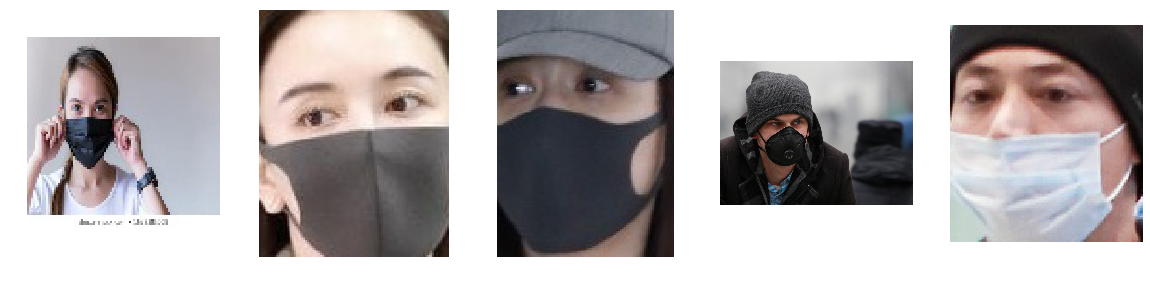

In [3]:
dUtils.ReadAndDisplayInputImages(FACE_MASK_TYPE.MASKED.value, 5)

#### Un-Masked Faces

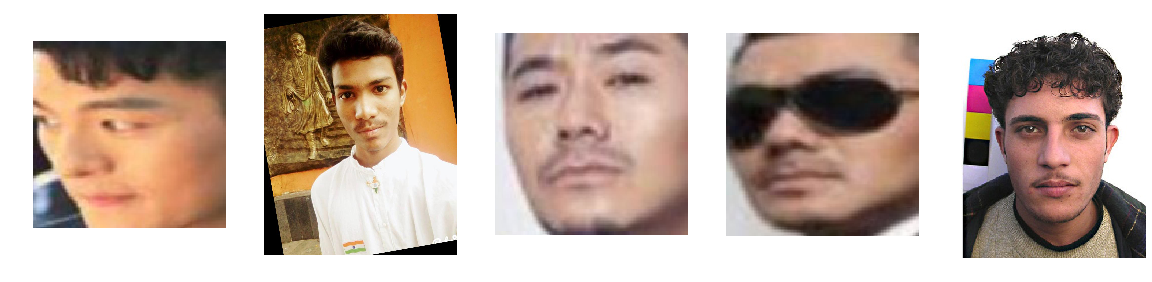

In [4]:
dUtils.ReadAndDisplayInputImages(FACE_MASK_TYPE.NON_MASKED.value, 5)

### Labelled Dataset

In [5]:
face_masked_df = dUtils.GetLabelledFaceMaskData()

dUtils.PrintMarkdownText('***Labelled Face Mask Data...***')
face_masked_df.head()

<br>

***Labelled Face Mask Data...***

,filename,label
0,facial-images/with_mask/0_0_0 copy 94.jpg,Masked
1,facial-images/without_mask/0_0_wangdongcheng_0...,UnMasked
2,facial-images/without_mask/0_0_guanyue_0083.jpg,UnMasked
3,facial-images/without_mask/augmented_image_151...,UnMasked
4,facial-images/without_mask/1_0_anhu_0134.jpg,UnMasked


<br>

***Sample Annotated MASKED & NON_MASKED Images...***

/mnt/disks/user/project/Face_Mask_Detector/DataUtility.py:291: FutureWarning: `item` has been deprecated and will be removed in a future version
  plt.title(labels[i].item())


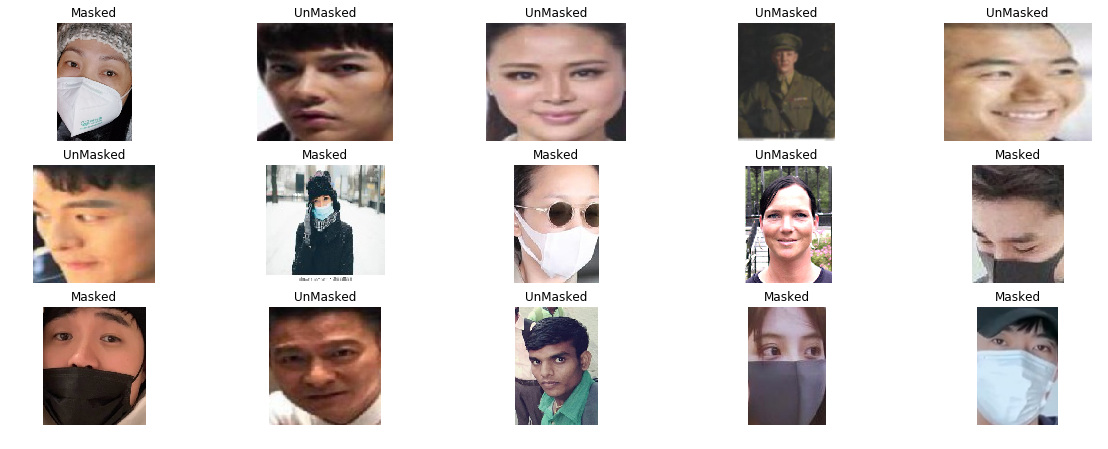

In [6]:
dUtils.PrintMarkdownText('***Sample Annotated MASKED & NON_MASKED Images...***')
dUtils.DisplayAnnotatedImages(face_masked_df, 15)

### Test-Train-Validation Split

In [7]:
train_files, test_files, train_labels, test_labels = train_test_split(face_masked_df['filename'].values,
                                                                      face_masked_df['label'].values, 
                                                                      test_size=0.80, random_state=42)

In [8]:
dUtils.PrintMarkdownText('***Length of the generated datasets...***')

print(" -- Train Set Length: " + str(len(train_files)) + ' samples'
      "\n -- Test Set Length: " + str(len(test_files)) + ' samples')

<br>

***Length of the generated datasets...***

 -- Train Set Length: 766 samples
 -- Test Set Length: 3066 samples


In [9]:
dUtils.PrintMarkdownText('***Tally of occurrences of the 2 labels in the generated datasets...***')

print('Training Data:', Counter(train_labels), 
      '\n\nTest Data:', Counter(test_labels))

<br>

***Tally of occurrences of the 2 labels in the generated datasets...***

Training Data: Counter({'Masked': 395, 'UnMasked': 371}) 

Test Data: Counter({'UnMasked': 1545, 'Masked': 1521})


### Label Encoding

In [10]:
lbl_encoder = LabelEncoder()
lbl_encoder.fit(train_labels)

y_train = lbl_encoder.transform(train_labels)
y_test = lbl_encoder.transform(test_labels)

dUtils.PrintMarkdownText('***Categorical & Encoded Training Labels...***')
print("Categorical Train Labels:", list(train_labels[:5]), 
      "\n\nEncoded Train Labels:    ", y_train[:5])

<br>

***Categorical & Encoded Training Labels...***

Categorical Train Labels: ['Masked', 'Masked', 'Masked', 'UnMasked', 'UnMasked'] 

Encoded Train Labels:     [0 0 0 1 1]


In [11]:
dUtils.PrintMarkdownText('***Categorical & Encoded Test Labels...***')
print("Categorical Train Labels:", list(test_labels[:5]), 
      "\n\nEncoded Train Labels:    ", y_test[:5])

<br>

***Categorical & Encoded Test Labels...***

Categorical Train Labels: ['Masked', 'Masked', 'Masked', 'Masked', 'UnMasked'] 

Encoded Train Labels:     [0 0 0 0 1]


### Image Resize

In [12]:
IMG_RESIZE_DIMS = (64, 64)

train_data = dUtils.ResizeAllImages(train_files, IMG_RESIZE_DIMS)
test_data = dUtils.ResizeAllImages(test_files, IMG_RESIZE_DIMS)

### Model Creation

In [14]:
BATCH_SIZE = 16
NUM_CLASSES = 2
EPOCHS = 30
BASE_LR = 1e-4
INPUT_SHAPE = (64, 64, 3)

In [17]:
classifier = Sequential(name = 'classifier')
classifier.add(Conv2D(32,(3,3),input_shape = INPUT_SHAPE, activation = 'relu'))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size = (2,2)))

classifier.add(Conv2D(64,(3,3), activation = 'relu'))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size = (2,2)))

classifier.add(Conv2D(128,(3,3), activation = 'relu'))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size = (2,2)))

classifier.add(Flatten())
classifier.add(Dropout(0.5))
classifier.add(Dense(50, activation='relu'))
classifier.add(Dense(1, activation = 'sigmoid'))

classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

### Model Checkpoints

In [18]:
filepath = './' + classifier.name + '.h5'
print("Model Checkpoint (.h5 file) Path:", filepath)

Model_Check_Point = ModelCheckpoint(filepath, 
                             monitor = 'val_loss', 
                             verbose = 1, 
                             save_best_only = True, 
                             save_weights_only = False, 
                             mode = 'auto', 
                             save_freq = 'epoch')

Learning_Rate = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 2, cooldown = 1, verbose = 1)
Early_Stop = EarlyStopping(monitor = 'val_loss', patience = 7, verbose = 1, mode = 'auto')

callback_list = [Model_Check_Point]

Model Checkpoint (.h5 file) Path: ./classifier.h5


### Data Augmentation

In [19]:
# construct the training image generator for data augmentation
train_data_augmentor = ImageDataGenerator(rescale=1.0/255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

validation_data_augmentor = ImageDataGenerator(rescale=1./255)

train_gen = train_data_augmentor.flow(train_data, y_train, batch_size=BATCH_SIZE, shuffle=True)
val_gen = validation_data_augmentor.flow(test_data, y_test, batch_size=BATCH_SIZE, shuffle=False)

### Train the Model - Model Fit

In [20]:
train_history = classifier.fit(train_gen,
                          steps_per_epoch=len(train_data) // BATCH_SIZE, 
                          epochs=EPOCHS,
                          validation_data=val_gen, 
                          validation_steps=len(test_data) // BATCH_SIZE,
                          callbacks=callback_list,
                          verbose=1)

Epoch 1/30
46/47 [============================>.] - ETA: 0s - loss: 0.6583 - accuracy: 0.7745
Epoch 00001: val_loss improved from inf to 0.62719, saving model to ./classifier.h5
47/47 [==============================] - 2s 45ms/step - loss: 0.6545 - accuracy: 0.7739 - val_loss: 0.6272 - val_accuracy: 0.6679
Epoch 2/30
46/47 [============================>.] - ETA: 0s - loss: 0.3411 - accuracy: 0.8719
Epoch 00002: val_loss did not improve from 0.62719
47/47 [==============================] - 2s 37ms/step - loss: 0.3409 - accuracy: 0.8720 - val_loss: 0.7225 - val_accuracy: 0.6466
Epoch 3/30
46/47 [============================>.] - ETA: 0s - loss: 0.3449 - accuracy: 0.8678
Epoch 00003: val_loss did not improve from 0.62719
47/47 [==============================] - 2s 38ms/step - loss: 0.3403 - accuracy: 0.8693 - val_loss: 2.3716 - val_accuracy: 0.5052
Epoch 4/30
46/47 [============================>.] - ETA: 0s - loss: 0.3113 - accuracy: 0.9005
Epoch 00004: val_loss improved from 0.62719 to 0

Epoch 30/30
46/47 [============================>.] - ETA: 0s - loss: 0.1257 - accuracy: 0.9428
Epoch 00030: val_loss did not improve from 0.13643
47/47 [==============================] - 2s 41ms/step - loss: 0.1256 - accuracy: 0.9413 - val_loss: 0.1756 - val_accuracy: 0.9332


### Deploy the model to local Web Cam for Live Mask Detection

In [2]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

model = load_model('classifier.h5')

video_capture = cv2.VideoCapture(0)

while True:
    ret,frame =video_capture.read() 
    res_frame = cv2.resize(frame, (frame.shape[1] // 4, frame.shape[0] //4))
    faces = face_cascade.detectMultiScale(res_frame)
    for f in faces:
        (x, y, w, h) = [v * 4 for v in f] 
        face_img = frame[y:y+h, x:x+w]
        resized = cv2.resize(face_img,(64,64))
        normalized = resized/255.0
        reshaped = np.reshape(normalized,(1,64,64,3))
        reshaped = np.vstack([reshaped])
        result = model.predict(reshaped)
        if result >= 0.8:
            prediction = 'Without Mask'
            cv2.rectangle(frame,(x,y),(x+w,y+h),(0,0,255),2)
            cv2.putText(frame, prediction, (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(0,0,255),2)
        else:
            prediction = 'With Mask'
            cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)
            cv2.putText(frame, prediction, (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(0,255,0),2)
        
    
    cv2.imshow('Face_Mask_Detector', frame)

    if cv2.waitKey(1) == 27:
        break
    if cv2.getWindowProperty('Face_Mask_Detector',cv2.WND_PROP_VISIBLE) < 1:        
        break

video_capture.release()
cv2.destroyAllWindows()